In [1]:
import sys
sys.path.insert(0, "/cndd/fangming/CEMBA/snmcseq_dev")

from multiprocessing import Pool,cpu_count
from functools import partial

from scipy import sparse
from scipy import stats
import importlib
from __init__ import *
from __init__jupyterlab import *
import snmcseq_utils
importlib.reload(snmcseq_utils)

import pickle
import datetime

# Todo
tune k
- organize the notebook to take different k
- generates different k from scf efficiently
- run it here

work on the plots
- disconnected y axis
- report number and fraction of correlated pairs...

maybe
- check the enhancer-gene linkage file match 

In [2]:
today = datetime.date.today()
print(today)

input_enh_gene_table = '/cndd2/fangming/projects/scf_enhancers/results/200521_to_evals.tsv' 

output_corr = '/cndd2/fangming/projects/scf_enhancers/results/{}_corrs_test1.pkl'.format(today)
output_to_correlate = "/cndd2/fangming/projects/scf_enhancers/results/{}_corrs_idx_test1.pkl".format(today)
output_figure1 = '/cndd2/fangming/projects/scf_enhancers/results/figures/{}_cell_level_mc_rna_corr_v1.pdf'.format(today)
output_figure2 = '/cndd2/fangming/projects/scf_enhancers/results/figures/{}_cell_level_mc_rna_corr_v2.pdf'.format(today)

2020-08-03


# Load data 

In [3]:
# enhancer-gene linkage
ti = time.time()
enhancer_gene_to_eval = pd.read_csv(input_enh_gene_table, sep='\t')

print(enhancer_gene_to_eval.shape)
print(time.time()-ti)
enhancer_gene_to_eval.head()

(2589994, 18)
7.403596639633179


,gene,ens,val,val2,val_clustershuffled,val2_clustershuffled,dist,pvalues,fdr<100kb,fdr<200kb,fdr<500kb,fdr<100kb shuffled (cluster label),pvalues2,fdr2<100kb,fdr2<200kb,fdr2<500kb,fdr2<100kb shuffled (cluster label),val_both
0,ENSMUSG00000000001,147520,-0.157895,0.127913,-0.169712,-0.049349,995118,0.288079,0.674683,0.736811,0.827139,1.647931,0.383141,0.745977,0.797076,0.872822,1.955898,-0.285808
1,ENSMUSG00000000001,147522,0.027465,-0.307145,0.064887,0.105591,985740,0.561881,0.830849,0.867082,0.917381,0.958300,0.935264,0.973809,0.979844,0.987476,0.959470,0.334610
2,ENSMUSG00000000001,147523,-0.040376,0.011489,-0.155487,0.014772,983725,0.457686,0.780196,0.825259,0.889141,1.089312,0.580703,0.841673,0.874844,0.922832,1.273339,-0.051866
3,ENSMUSG00000000001,147527,-0.070795,0.111719,-0.088084,0.184594,970444,0.411564,0.755088,0.804341,0.874375,1.183332,0.410358,0.761056,0.809464,0.880982,1.812516,-0.182514
4,ENSMUSG00000000001,147528,0.012583,0.150673,-0.036218,0.147609,969372,0.539123,0.819981,0.858026,0.911467,0.979843,0.345993,0.725803,0.780447,0.862033,2.191506,-0.138090


In [4]:
# input_bundle
f = '/cndd2/fangming/projects/scf_enhancers/data/organized_cell_level/version_july29'
bundle_fnames = (
    'cell_smarter_cells.txt',
    'cell_snmcseq_gene.txt',
    'gene_smarter_cells.txt',
    'enh_snmcseq_gene.tsv',
    
    'mat_smarter_cells.npz',
    'mat_mcg_snmcseq_gene.npz',
    'mat_cg_snmcseq_gene.npz',
    'knn_smarter_cells_snmcseq_gene.npz',
    'knn_smarter_cells.npz',
)


ti = time.time()
with snmcseq_utils.cd(f):
    bundle = []
    for fname in bundle_fnames:
        #  save all as pickle file
        with open(fname, "rb") as fh:
            item = pickle.load(fh)
        bundle.append(item)
        print(type(item), item.shape, fname, time.time()-ti)

(common_rna_cells, common_mc_cells, 
 common_genes, common_enhancer_regions,
 X, Y_mcg, Y_cg, knn_xy, knn_xx,
) = bundle

print(time.time()-ti)

<class 'numpy.ndarray'> (6244,) cell_smarter_cells.txt 0.0017499923706054688
<class 'numpy.ndarray'> (9364,) cell_snmcseq_gene.txt 0.0041081905364990234
<class 'numpy.ndarray'> (32324,) gene_smarter_cells.txt 0.009328365325927734
<class 'pandas.core.frame.DataFrame'> (233514, 3) enh_snmcseq_gene.tsv 0.018721580505371094
<class 'scipy.sparse.csc.csc_matrix'> (32324, 6244) mat_smarter_cells.npz 0.4528675079345703
<class 'scipy.sparse.csc.csc_matrix'> (233514, 9364) mat_mcg_snmcseq_gene.npz 2.203281879425049
<class 'scipy.sparse.csc.csc_matrix'> (233514, 9364) mat_cg_snmcseq_gene.npz 5.031628608703613
<class 'scipy.sparse.csc.csc_matrix'> (6244, 9364) knn_smarter_cells_snmcseq_gene.npz 5.091436386108398
<class 'scipy.sparse.csc.csc_matrix'> (6244, 6244) knn_smarter_cells.npz 5.161383867263794
5.162255525588989


# Compute metacell level signal 

In [5]:
ti = time.time()

# gene by metacell
gc_rna = X.dot(knn_xx.T).todense() 

# enhancer by metacell
ec_cg = Y_cg.dot(knn_xy.T).todense() 
ec_mcg = Y_mcg.dot(knn_xy.T).todense()  

print(time.time()-ti)

print(gc_rna.shape, ec_cg.shape, ec_mcg.shape)

137.49766182899475
(32324, 6244) (233514, 6244) (233514, 6244)


In [6]:
# get mcc
ti = time.time()
ec_mccg =  snmcseq_utils.get_mcc_lite_v4(
                                pd.DataFrame(ec_cg).astype(np.float32), 
                                pd.DataFrame(ec_mcg).astype(np.float32), 
                                base_call_cutoff=5, sufficient_coverage_fraction=0.8, fillna=True)
print(ec_mccg.shape)

print(time.time()-ti)

(87943, 6244)
402.9690866470337


## Correlate enhancer and gene (a new notebook)

In [7]:
def row_dot_product_norm_by_numcol(X_zscore, Y_zscore, x_idx, y_idx, 
                                   chunksize=10000, verbose_level=100000):
    """compute (X_zscore[x_idx]*Y_zscore[y_idx]).mean(axis=1)
    correlation values given matched x_idx and y_idx...
    """
    assert len(x_idx) == len(y_idx)
    num_pairs = len(x_idx)
    corrs = []
    for pair_idx in snmcseq_utils.chunks(np.arange(num_pairs), chunksize):
        if pair_idx[0] % verbose_level == 0:
            print(pair_idx[0], time.time()-ti)

        _res = (X_zscore[x_idx[pair_idx]]*Y_zscore[y_idx[pair_idx]]).mean(axis=1)
        corrs.append(_res)
    corrs = np.hstack(corrs) 
    return corrs 

In [8]:
gc_rna_zscore = stats.zscore(np.array(gc_rna), axis=1, ddof=0, nan_policy='propagate')
ec_mccg_zscore = stats.zscore(ec_mccg.values, axis=1, ddof=0, nan_policy='propagate')

/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packages/scipy/stats/stats.py:2419: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


In [9]:
# use ec_mccg and gc_rna
ti = time.time()

# correlate e-g according to a e-g table
gene_idx = snmcseq_utils.get_index_from_array(common_genes, enhancer_gene_to_eval['gene'])
enh_idx = snmcseq_utils.get_index_from_array(ec_mccg.index.values, enhancer_gene_to_eval['ens']) # be careful here!
to_correlate = ~np.logical_or(gene_idx==-1, enh_idx==-1)

with open(output_to_correlate, "wb") as fh:
    pickle.dump(to_correlate, fh)

gene_idx = gene_idx[to_correlate]
enh_idx = enh_idx[to_correlate]
print(gene_idx.shape, enh_idx.shape)
print(time.time()-ti)

# corr
corrs = row_dot_product_norm_by_numcol(gc_rna_zscore, ec_mccg_zscore, gene_idx, enh_idx)
print(time.time()-ti)

# corr shuffled cells
corrs_shuffled_cells = row_dot_product_norm_by_numcol(
    gc_rna_zscore[:,np.random.permutation(gc_rna_zscore.shape[1])], 
    ec_mccg_zscore, 
    gene_idx, enh_idx)
print(time.time()-ti)

# corr shuffled genes (break up the pairs)
gene_idx_uniq = np.unique(gene_idx)
shuff_genes = {
    gene: gene_shuff for gene, gene_shuff in 
        zip(gene_idx_uniq, gene_idx_uniq[np.random.permutation(len(gene_idx_uniq))])
    }
gene_idx_shuff = np.array([shuff_genes[gene] for gene in gene_idx])

corrs_shuffled = row_dot_product_norm_by_numcol(
    gc_rna_zscore, 
    ec_mccg_zscore, 
    gene_idx_shuff, enh_idx)

print(time.time()-ti)

(1543535,) (1543535,)
0.3367586135864258
0 0.3394777774810791
100000 6.240134239196777
200000 11.925537586212158
300000 17.578617811203003
400000 23.203196048736572
500000 28.86014461517334
600000 34.457422733306885
700000 40.19359493255615
800000 46.138012409210205
900000 52.0337655544281
1000000 58.017786502838135
1100000 63.982911109924316
1200000 69.98134422302246
1300000 75.89198899269104
1400000 81.90875220298767
1500000 87.87138938903809
90.4498016834259
0 90.92689752578735
100000 96.79654693603516
200000 102.47967457771301
300000 108.09664368629456
400000 113.73614311218262
500000 119.34076952934265
600000 124.98088431358337
700000 130.67486476898193
800000 136.61954951286316
900000 142.5262975692749
1000000 148.5549657344818
1100000 154.5135326385498
1200000 160.48484063148499
1300000 166.421391248703
1400000 172.40126061439514
1500000 178.40518283843994
181.02643990516663
0 181.3847942352295
100000 187.28745937347412
200000 193.0390408039093
300000 198.68623805046082
400000 2

In [10]:
# save corrs 
ti = time.time()
with open(output_corr, 'wb') as fh:
    pickle.dump((corrs, corrs_shuffled, corrs_shuffled_cells), fh)
print(time.time()-ti)

0.13160109519958496


# plotting results

In [232]:
import sys
sys.path.insert(0, "/cndd/fangming/CEMBA/snmcseq_dev")

from multiprocessing import Pool,cpu_count
from functools import partial

from scipy import sparse
from scipy import stats
import importlib
from __init__ import *
from __init__jupyterlab import *
import snmcseq_utils
importlib.reload(snmcseq_utils)

import pickle
import datetime
from scipy import optimize

In [233]:
today = datetime.date.today()
print(today)

input_enh_gene_table = '/cndd2/fangming/projects/scf_enhancers/results/200521_to_evals.tsv' 

# output_corr = '/cndd2/fangming/projects/scf_enhancers/results/{}_corrs_test1.pkl'.format(today)
# output_to_correlate = "/cndd2/fangming/projects/scf_enhancers/results/{}_corrs_idx_test1.pkl".format(today)
output_corr = '/cndd2/fangming/projects/scf_enhancers/results/corr_analysis_smarter_cells_snmcseq_gene_ka2_k2_200803_2020-08-03_corrs.pkl'
output_to_correlate = "/cndd2/fangming/projects/scf_enhancers/results/corr_analysis_smarter_cells_snmcseq_gene_ka2_k2_200803_2020-08-03_corrs_idx.pkl"

output_figure1 = '/cndd2/fangming/projects/scf_enhancers/results/figures/{}_cell_level_mc_rna_corr_v1.pdf'.format(today)
output_figure2 = '/cndd2/fangming/projects/scf_enhancers/results/figures/{}_cell_level_mc_rna_corr_v2.pdf'.format(today)

2020-08-04


In [234]:
# enhancer-gene linkage
ti = time.time()
enhancer_gene_to_eval = pd.read_csv(input_enh_gene_table, sep='\t')

print(enhancer_gene_to_eval.shape)
print(time.time()-ti)
enhancer_gene_to_eval.head()

(2589994, 18)
7.207625150680542


,gene,ens,val,val2,val_clustershuffled,val2_clustershuffled,dist,pvalues,fdr<100kb,fdr<200kb,fdr<500kb,fdr<100kb shuffled (cluster label),pvalues2,fdr2<100kb,fdr2<200kb,fdr2<500kb,fdr2<100kb shuffled (cluster label),val_both
0,ENSMUSG00000000001,147520,-0.157895,0.127913,-0.169712,-0.049349,995118,0.288079,0.674683,0.736811,0.827139,1.647931,0.383141,0.745977,0.797076,0.872822,1.955898,-0.285808
1,ENSMUSG00000000001,147522,0.027465,-0.307145,0.064887,0.105591,985740,0.561881,0.830849,0.867082,0.917381,0.958300,0.935264,0.973809,0.979844,0.987476,0.959470,0.334610
2,ENSMUSG00000000001,147523,-0.040376,0.011489,-0.155487,0.014772,983725,0.457686,0.780196,0.825259,0.889141,1.089312,0.580703,0.841673,0.874844,0.922832,1.273339,-0.051866
3,ENSMUSG00000000001,147527,-0.070795,0.111719,-0.088084,0.184594,970444,0.411564,0.755088,0.804341,0.874375,1.183332,0.410358,0.761056,0.809464,0.880982,1.812516,-0.182514
4,ENSMUSG00000000001,147528,0.012583,0.150673,-0.036218,0.147609,969372,0.539123,0.819981,0.858026,0.911467,0.979843,0.345993,0.725803,0.780447,0.862033,2.191506,-0.138090


In [235]:
with open(output_corr, 'rb') as fh:
    corrs, corrs_shuffled, corrs_shuffled_cells = pickle.load(fh)
print(corrs.shape, corrs_shuffled.shape, corrs_shuffled_cells.shape)

with open(output_to_correlate, 'rb') as fh:
    to_correlate = pickle.load(fh)
print(to_correlate.shape)

(1546436,) (1546436,) (1546436,)
(2589994,)


In [236]:
dists = enhancer_gene_to_eval.loc[to_correlate, 'dist'].values
print(np.min(dists), np.max(dists))

2067 999999


In [275]:
uniq_enh = enhancer_gene_to_eval.loc[to_correlate, 'ens'].unique()
uniq_gene = enhancer_gene_to_eval.loc[to_correlate, 'gene'].unique()
print(len(uniq_enh), len(uniq_gene))

86649 18823


In [276]:
config = {
    'kde': False,
    "hist_kws": {
                'histtype': 'step', 
#                 'edgecolor': 'none',
                'alpha': 1, 
                'density': True, 
                },
}

colors = snmcseq_utils.get_grad_colors(5, cmap='Blues_r')
tracks = {
    'pairs (<100kb)': corrs[dists<1e5], 
    'pairs (<500kb)': corrs[dists<5e5], 
    'pairs (<1Mb)': corrs, 
    'shuffled pairs': corrs_shuffled, 
    'shuffled cells': corrs_shuffled_cells, 
    }

track_colors = {
    'pairs (<100kb)': colors[0], 
    'pairs (<500kb)': colors[1], 
    'pairs (<1Mb)': colors[2], 
    'shuffled pairs': 'gray', 
    'shuffled cells': 'gray', 
    }


num_bins = 200
bins = np.linspace(-1, 0.3, num_bins)

fdr_threshold = 0.2

track_pdf_ratios = {}
track_cdfs = {}
track_fdrs = {}

track_r_thresholds = {}
track_num_sigs = {}
track_frac_sigs = {}

track_r_thresholds_cells = {}
track_num_sigs_cells = {}
track_frac_sigs_cells = {}

hist_shuff, _ = np.histogram(corrs_shuffled, bins=bins, normed=True)
cdf_shuff = np.cumsum(hist_shuff)
hist_shuff_cells, _ = np.histogram(corrs_shuffled_cells, bins=bins, normed=True)
cdf_shuff_cells = np.cumsum(hist_shuff_cells)
for label, track in tracks.items():
    # dist
    hist, _ = np.histogram(track, bins=bins, normed=True)
    cdf = np.cumsum(hist)
    # fdr
    fdr = cdf_shuff/cdf
    fdr_cells = cdf_shuff_cells/cdf
    # record
    track_pdf_ratios[label] = hist/hist_shuff
    track_cdfs[label] = cdf 
    track_fdrs[label] = fdr
    
    if label.startswith("pairs"):
        # get r_threshold
        # remove nan
        isnan = np.isnan(fdr)
        _y = fdr[~isnan]
        _x = bins[1:][~isnan]

        # find r threshold
        try:
            f = lambda _x_func: np.interp(_x_func, _x, _y) - fdr_threshold
            r_threshold = optimize.root_scalar(f, bracket=(-1, 0)).root
        except:
            r_threshold = 0
    
        # num and frac significant
        num_sig = np.sum(track < r_threshold)
        frac_sig = num_sig/len(track)
        
        # record
        track_r_thresholds[label] = r_threshold 
        track_num_sigs[label] = num_sig
        track_frac_sigs[label] = frac_sig
    
        ## shuff cells
        # get r_threshold
        # remove nan
        isnan = np.isnan(fdr_cells)
        _y = fdr_cells[~isnan]
        _x = bins[1:][~isnan]

        # find r threshold
        try:
            f = lambda _x_func: np.interp(_x_func, _x, _y) - fdr_threshold
            r_threshold = optimize.root_scalar(f, bracket=(-1, 0)).root
        except:
            r_threshold = 0
    
        # num and frac significant
        num_sig = np.sum(track < r_threshold)
        frac_sig = num_sig/len(track)
        
        # record
        track_r_thresholds_cells[label] = r_threshold 
        track_num_sigs_cells[label] = num_sig
        track_frac_sigs_cells[label] = frac_sig

/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide
/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in true_divide
/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide
/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide


In [267]:
track_num_sigs

{'pairs (<100kb)': 4514, 'pairs (<1Mb)': 158, 'pairs (<500kb)': 303}

In [277]:
track_num_sigs_cells

{'pairs (<100kb)': 91178, 'pairs (<1Mb)': 830985, 'pairs (<500kb)': 437713}

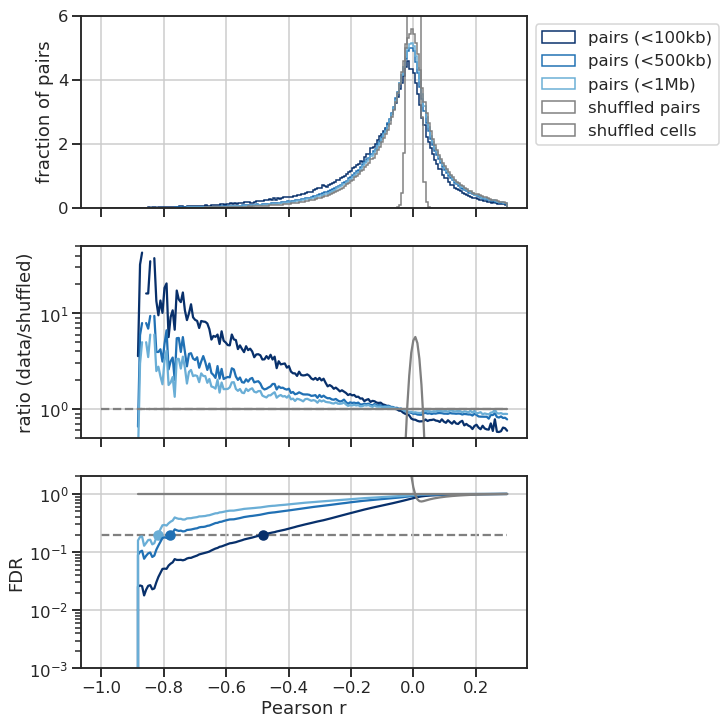

In [238]:
# figure 2
fig, axs = plt.subplots(3, 1, figsize=(4*2,4*3), sharex=True)

ax = axs[0]
for label, track in tracks.items():
    sns.distplot(track, bins=bins, ax=ax, label=label, color=track_colors[label], **config)
ax.legend(bbox_to_anchor=(1,1), loc='upper left')
ax.set_ylabel('fraction of pairs')
ax.set_ylim([0, 6])

ax = axs[1]
for label, track in track_pdf_ratios.items():
    ax.plot(bins[1:], track, label="data/shuffled", color=track_colors[label])
ax.set_yscale('log')
ax.hlines(1, bins[0], bins[-1], linestyle='--', color='gray')
ax.set_ylabel('ratio (data/shuffled)')
ax.set_ylim([0.5, 50])

ax = axs[2]
for label, track in track_fdrs.items():
    ax.plot(bins[1:], track, color=track_colors[label])
    if label.startswith('pairs'):
        ax.scatter(track_r_thresholds[label], fdr_threshold, color=track_colors[label])
ax.hlines(fdr_threshold, bins[0], bins[-1], color='gray', linestyle='--', zorder=0)
    
ax.set_yscale('log')
ax.set_ylabel('FDR')
ax.set_xlabel('Pearson r')
ax.set_ylim([1e-3, 2])

snmcseq_utils.savefig(fig, output_figure2)
plt.show()

In [268]:
k = ka = 2

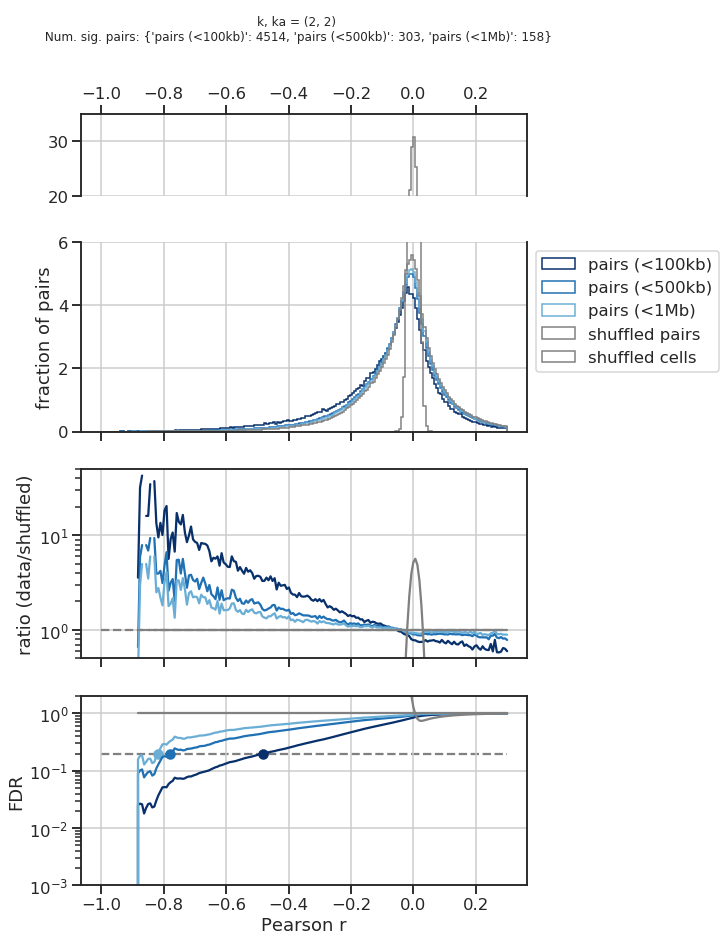

In [273]:
# figure 2
fig, axs = plt.subplots(4, 1, figsize=(4*2,4*4), sharex=True)
fig.suptitle("k, ka = ({}, {})\n Num. sig. pairs: {}".format(k, ka, track_num_sigs), y=0.88)

axs[0].axis('off')
ax = fig.add_subplot(912)
for label, track in tracks.items():
    sns.distplot(track, bins=bins, ax=ax, label=label, color=track_colors[label], **config)
ax.set_ylim([20, 35])
sns.despine(bottom=True, top=False, right=False, ax=ax)

ax = axs[1]
for label, track in tracks.items():
    sns.distplot(track, bins=bins, ax=ax, label=label, color=track_colors[label], **config)
ax.legend(bbox_to_anchor=(1,1), loc='upper left')
ax.set_ylabel('fraction of pairs')
ax.set_ylim([0, 6])
sns.despine(top=True, right=False, ax=ax)

ax = axs[2]
for label, track in track_pdf_ratios.items():
    ax.plot(bins[1:], track, label="data/shuffled", color=track_colors[label])
ax.set_yscale('log')
ax.hlines(1, bins[0], bins[-1], linestyle='--', color='gray')
ax.set_ylabel('ratio (data/shuffled)')
ax.set_ylim([0.5, 50])

ax = axs[3]
for label, track in track_fdrs.items():
    ax.plot(bins[1:], track, color=track_colors[label])
    if label.startswith('pairs'):
        ax.scatter(track_r_thresholds[label], fdr_threshold, color=track_colors[label])
ax.hlines(fdr_threshold, bins[0], bins[-1], color='gray', linestyle='--', zorder=0)
    
ax.set_yscale('log')
ax.set_ylabel('FDR')
ax.set_xlabel('Pearson r')
ax.set_ylim([1e-3, 2])

snmcseq_utils.savefig(fig, output_figure2)
plt.show()

# Visualizations 

# Plot massive 

In [281]:
import sys
sys.path.insert(0, "/cndd/fangming/CEMBA/snmcseq_dev")

from multiprocessing import Pool,cpu_count
from functools import partial

from scipy import sparse
from scipy import stats
import importlib
from __init__ import *
from __init__jupyterlab import *
import snmcseq_utils
importlib.reload(snmcseq_utils)

import pickle
import datetime
from scipy import optimize
import re

In [213]:
today = datetime.date.today()
print(today)

2020-08-04


In [214]:
input_enh_gene_table = '/cndd2/fangming/projects/scf_enhancers/results/200521_to_evals.tsv' 
output_corr_format = '/cndd2/fangming/projects/scf_enhancers/results/corr_analysis_smarter_cells_snmcseq_gene_ka{}_k{}_200803_2020-08-03_corrs.pkl'
output_to_correlate_format = "/cndd2/fangming/projects/scf_enhancers/results/corr_analysis_smarter_cells_snmcseq_gene_ka{}_k{}_200803_2020-08-03_corrs_idx.pkl"

output_figure1 = '/cndd2/fangming/projects/scf_enhancers/results/figures/{}_num_sig_dependency_ka_k_v1.pdf'.format(today)
output_figure2 = '/cndd2/fangming/projects/scf_enhancers/results/figures/{}_num_sig_dependency_ka_k_v2.pdf'.format(today)
output_figure3 = '/cndd2/fangming/projects/scf_enhancers/results/figures/{}_num_sig_dependency_ka_k_v3.pdf'.format(today)
output_figure4 = '/cndd2/fangming/projects/scf_enhancers/results/figures/{}_num_sig_dependency_ka_k_v4.pdf'.format(today)

In [215]:
# enhancer-gene linkage
enhancer_gene_to_eval = pd.read_csv(input_enh_gene_table, sep='\t')
print(enhancer_gene_to_eval.shape)
enhancer_gene_to_eval.head()

(2589994, 18)


,gene,ens,val,val2,val_clustershuffled,val2_clustershuffled,dist,pvalues,fdr<100kb,fdr<200kb,fdr<500kb,fdr<100kb shuffled (cluster label),pvalues2,fdr2<100kb,fdr2<200kb,fdr2<500kb,fdr2<100kb shuffled (cluster label),val_both
0,ENSMUSG00000000001,147520,-0.157895,0.127913,-0.169712,-0.049349,995118,0.288079,0.674683,0.736811,0.827139,1.647931,0.383141,0.745977,0.797076,0.872822,1.955898,-0.285808
1,ENSMUSG00000000001,147522,0.027465,-0.307145,0.064887,0.105591,985740,0.561881,0.830849,0.867082,0.917381,0.958300,0.935264,0.973809,0.979844,0.987476,0.959470,0.334610
2,ENSMUSG00000000001,147523,-0.040376,0.011489,-0.155487,0.014772,983725,0.457686,0.780196,0.825259,0.889141,1.089312,0.580703,0.841673,0.874844,0.922832,1.273339,-0.051866
3,ENSMUSG00000000001,147527,-0.070795,0.111719,-0.088084,0.184594,970444,0.411564,0.755088,0.804341,0.874375,1.183332,0.410358,0.761056,0.809464,0.880982,1.812516,-0.182514
4,ENSMUSG00000000001,147528,0.012583,0.150673,-0.036218,0.147609,969372,0.539123,0.819981,0.858026,0.911467,0.979843,0.345993,0.725803,0.780447,0.862033,2.191506,-0.138090


In [216]:
# # 

# ka_list = [2, 5, 10, 20, 50, 100, 200] 
# k_list = [2, 50, 10, 20, 50, 100, 200]

# num_bins = 200
# bins = np.linspace(-1, 0.3, num_bins)
# fdr_threshold = 0.2
# label = 'pairs (<100kb)'


# res = []

# for ka in ka_list:
#     for k in k_list:
#         # 
#         output_corr = output_corr_format.format(ka, k)
#         output_to_correlate = output_to_correlate_format.format(ka, k)
        
#         # try loading the list
#         try:
#             with open(output_corr, 'rb') as fh:
#                 corrs, corrs_shuffled, corrs_shuffled_cells = pickle.load(fh)
#             print(corrs.shape, corrs_shuffled.shape, corrs_shuffled_cells.shape)

#             with open(output_to_correlate, 'rb') as fh:
#                 to_correlate = pickle.load(fh)
#             print(to_correlate.shape)
#         except:
#             continue
        
#         # dists 
#         dists = enhancer_gene_to_eval.loc[to_correlate, 'dist'].values
        
# #         ## total numbers
# #         num_total_pairs = len(enhancer_gene_to_eval[to_correlate])
# #         num_total_genes = len(enhancer_gene_to_eval[to_correlate]['gene'].unique())
# #         num_total_enhs = len(enhancer_gene_to_eval[to_correlate]['ens'].unique())
        
        
#         ## sig numbers
#         label_cond = dists < 1e5
#         track = corrs[label_cond]
        
#         ### total numbers with the condition
#         num_total_pairs = len(enhancer_gene_to_eval[to_correlate][label_cond])
#         num_total_genes = len(enhancer_gene_to_eval[to_correlate][label_cond]['gene'].unique())
#         num_total_enhs = len(enhancer_gene_to_eval[to_correlate][label_cond]['ens'].unique())

#         hist_shuff, _ = np.histogram(corrs_shuffled, bins=bins, normed=True)
#         cdf_shuff = np.cumsum(hist_shuff)
#         # dist
#         hist, _ = np.histogram(track, bins=bins, normed=True)
#         cdf = np.cumsum(hist)
#         # fdr
#         fdr = cdf_shuff/cdf

#         # get r_threshold
#         # remove nan
#         isnan = np.isnan(fdr)
#         _y = fdr[~isnan]
#         _x = bins[1:][~isnan]
#         # find r threshold
#         try:
#             f = lambda _x_func: np.interp(_x_func, _x, _y) - fdr_threshold
#             r_threshold = optimize.root_scalar(f, bracket=(-1, 0)).root
#         except:
#             r_threshold = 0

#         sig_table = enhancer_gene_to_eval[to_correlate][label_cond][track<r_threshold]

#         # num_sig
#         num_sig_pairs = len(sig_table)
#         num_sig_genes = len(sig_table['gene'].unique()) 
#         num_sig_enhs = len(sig_table['ens'].unique()) 

#         # record
#         res.append({
#             'ka': ka,
#             'k': k,
#             'num_total_pairs': num_total_pairs,
#             'num_total_genes': num_total_genes,
#             'num_total_enhs': num_total_enhs,
#             'num_sig_pairs': num_sig_pairs,
#             'num_sig_genes': num_sig_genes,
#             'num_sig_enhs': num_sig_enhs,
#             'r_threshold': r_threshold,
#         })
        
# res = pd.DataFrame(res)[[
#             'ka',
#             'k',
#             'num_sig_pairs',
#             'num_sig_genes',
#             'num_sig_enhs',
#             'r_threshold',
#             'num_total_pairs',
#             'num_total_genes',
#             'num_total_enhs',
# ]] 
# print(res.shape)
# res.head()

(1546436,) (1546436,) (1546436,)
(2589994,)


/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in true_divide


(1539635,) (1539635,) (1539635,)
(2589994,)
(1543164,) (1543164,) (1543164,)
(2589994,)
(1546273,) (1546273,) (1546273,)
(2589994,)
(1539635,) (1539635,) (1539635,)
(2589994,)
(1539798,) (1539798,) (1539798,)
(2589994,)
(1522985,) (1522985,) (1522985,)
(2589994,)
(1532335,) (1532335,) (1532335,)
(2589994,)
(1542719,) (1542719,) (1542719,)
(2589994,)
(1555150,) (1555150,) (1555150,)
(2589994,)
(1538700,) (1538700,) (1538700,)
(2589994,)
(1542719,) (1542719,) (1542719,)
(2589994,)
(1536987,) (1536987,) (1536987,)
(2589994,)
(1543970,) (1543970,) (1543970,)
(2589994,)
(1543906,) (1543906,) (1543906,)
(2589994,)
(1539561,) (1539561,) (1539561,)
(2589994,)
(1542335,) (1542335,) (1542335,)
(2589994,)
(1533257,) (1533257,) (1533257,)
(2589994,)
(1539561,) (1539561,) (1539561,)
(2589994,)
(1541895,) (1541895,) (1541895,)
(2589994,)
(1539550,) (1539550,) (1539550,)
(2589994,)
(1534403,) (1534403,) (1534403,)
(2589994,)
(1535991,) (1535991,) (1535991,)
(2589994,)
(1539372,) (1539372,) (1539372,)

,ka,k,num_sig_pairs,num_sig_genes,num_sig_enhs,r_threshold,num_total_pairs,num_total_genes,num_total_enhs
0,2,2,4514,894,4229,-0.481292,143311,17038,59180
1,2,50,4248,853,3986,-0.483757,142651,17021,58898
2,2,10,4689,922,4382,-0.467830,143047,17030,59044
3,2,20,4965,982,4628,-0.465951,143291,17044,59149
4,2,50,4248,853,3986,-0.483757,142651,17021,58898


In [217]:
res = res.groupby(['ka', 'k']).first().reset_index()
res.shape

(36, 9)

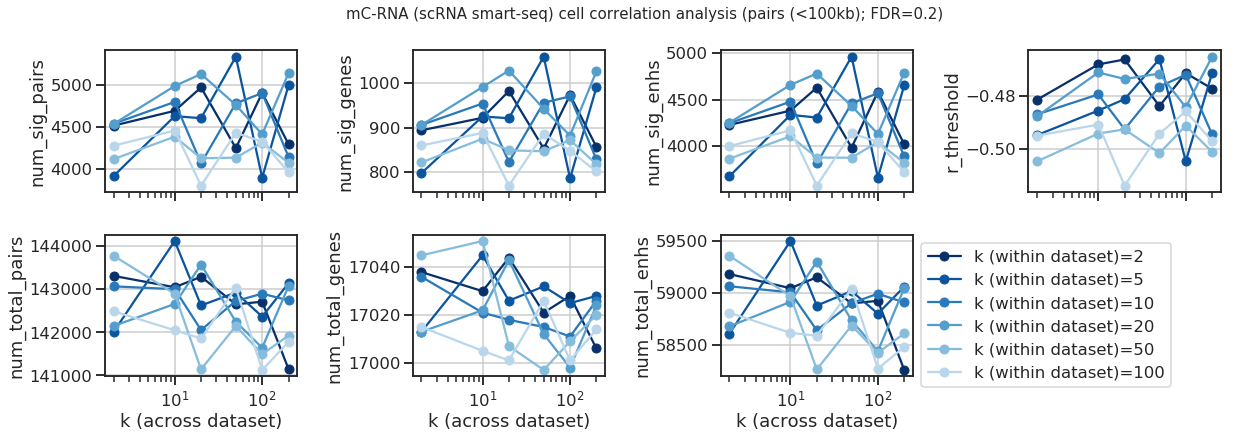

In [218]:
# plot (x - across)
fig, axs = plt.subplots(2, 4, figsize=(5*4, 3*2), sharex=True)
fig.suptitle('mC-RNA (scRNA smart-seq) cell correlation analysis ({}; FDR={})'.format(label, fdr_threshold), 
             fontsize=15)

axs = axs.flatten()
ka_colors = snmcseq_utils.get_grad_colors(len(res['ka'].unique())+2, cmap='Blues_r')
for i_ax, (ax, col) in enumerate(zip(axs, res.columns[2:])):
    for i, (ka, _table) in enumerate(res.groupby('ka')):
        _table = _table.sort_values('k')
        ax.plot(_table['k'], _table[col], '-o', 
                color=ka_colors[i], 
                label='k (within dataset)={}'.format(ka))

    ax.set_xscale('log')
    ax.set_ylabel(col)
    
    if i_ax >= 4:
        ax.set_xlabel('k (across dataset)')
    if i_ax == 6: 
        ax.legend(bbox_to_anchor=(1,1), loc='upper left')
        
axs[-1].axis('off') 
fig.subplots_adjust(wspace=0.6, hspace=0.3)
snmcseq_utils.savefig(fig, output_figure1)
plt.show()

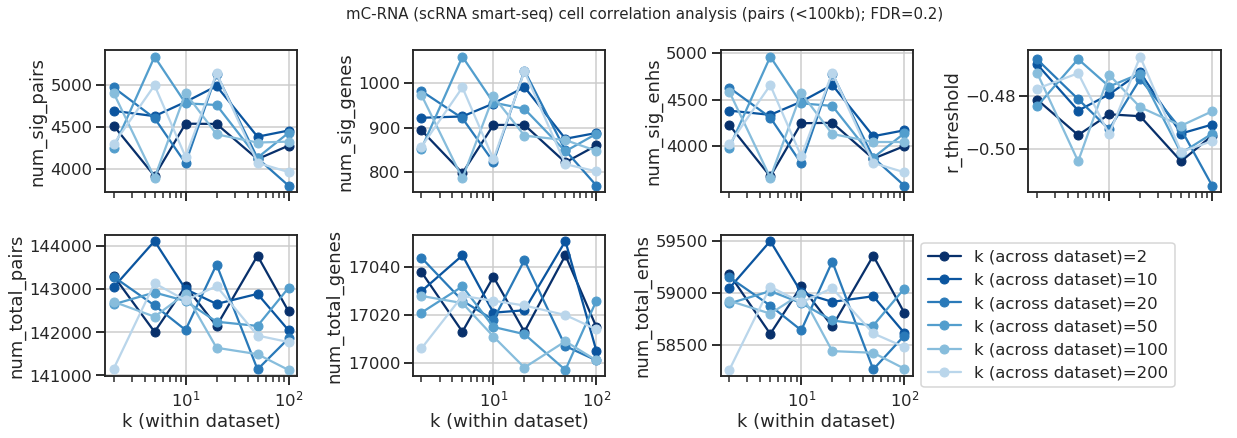

In [219]:
# plot (x - within)

fig, axs = plt.subplots(2, 4, figsize=(5*4, 3*2), sharex=True)
fig.suptitle('mC-RNA (scRNA smart-seq) cell correlation analysis ({}; FDR={})'.format(label, fdr_threshold), 
             fontsize=15)

axs = axs.flatten()
k_colors = snmcseq_utils.get_grad_colors(len(res['ka'].unique())+2, cmap='Blues_r')
for i_ax, (ax, col) in enumerate(zip(axs, res.columns[2:])):
    for i, (k, _table) in enumerate(res.groupby('k')):
        _table = _table.sort_values('ka')
        ax.plot(_table['ka'], _table[col], '-o', 
                color=k_colors[i], 
                label='k (across dataset)={}'.format(k))

    ax.set_xscale('log')
    ax.set_ylabel(col)
    
    if i_ax >= 4:
        ax.set_xlabel('k (within dataset)')
    if i_ax == 6: 
        ax.legend(bbox_to_anchor=(1,1), loc='upper left')
        
axs[-1].axis('off') 
fig.subplots_adjust(wspace=0.6, hspace=0.3)
snmcseq_utils.savefig(fig, output_figure2)
plt.show()

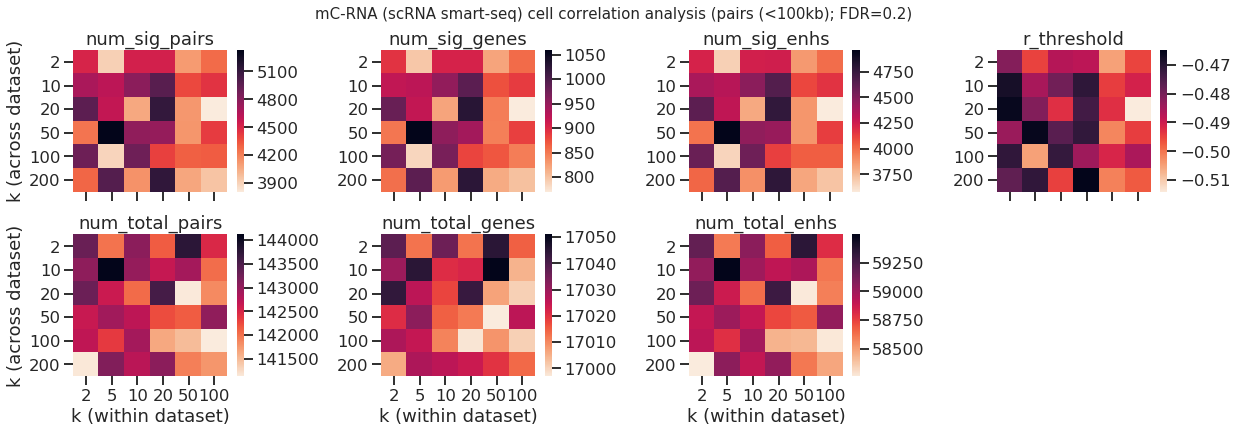

In [221]:
res_pivot = pd.pivot(res, index='k', columns='ka')

# plot same ks
fig, axs = plt.subplots(2, 4, figsize=(5*4, 3*2), sharex=True)
fig.suptitle('mC-RNA (scRNA smart-seq) cell correlation analysis ({}; FDR={})'.format(label, fdr_threshold), 
             fontsize=15)

axs = axs.flatten()
k_colors = snmcseq_utils.get_grad_colors(len(res['ka'].unique())+2, cmap='Blues_r')
_table = res[res['ka']==res['k']]
_table = _table.sort_values('ka')
for i_ax, (ax, col) in enumerate(zip(axs, res.columns[2:])):
    sns.heatmap(res_pivot[col], cmap='rocket_r', ax=ax)

    ax.set_title(col)
    
    if i_ax in (0, 4):
        ax.set_ylabel('k (across dataset)')
    else:
        ax.set_ylabel('')
        
    if i_ax >= 4:
        ax.set_xlabel('k (within dataset)')
    else:
        ax.set_xlabel('')
        
        
axs[-1].axis('off') 
fig.subplots_adjust(wspace=0.6, hspace=0.3)
snmcseq_utils.savefig(fig, output_figure4)
plt.show()

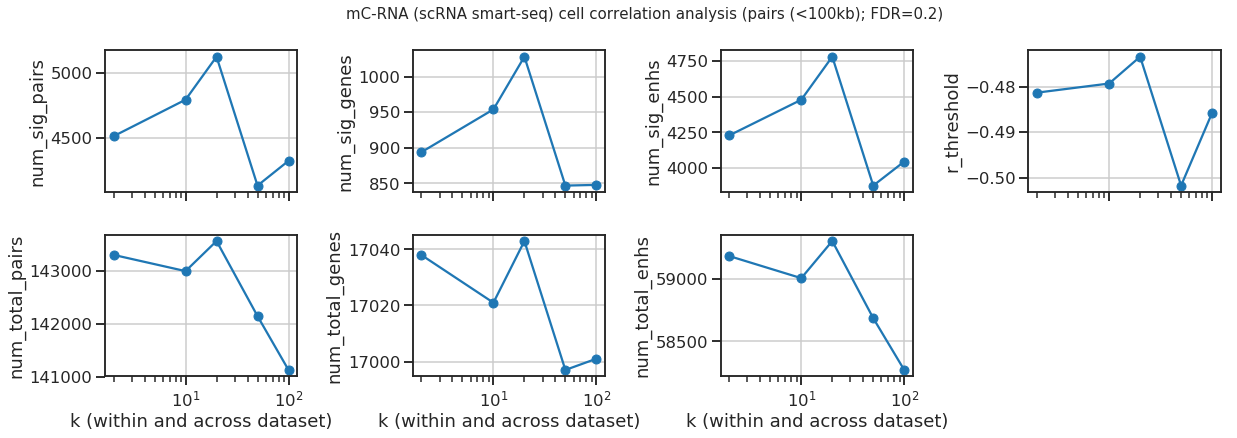

In [220]:
# plot same ks

fig, axs = plt.subplots(2, 4, figsize=(5*4, 3*2), sharex=True)
fig.suptitle('mC-RNA (scRNA smart-seq) cell correlation analysis ({}; FDR={})'.format(label, fdr_threshold), 
             fontsize=15)

axs = axs.flatten()
k_colors = snmcseq_utils.get_grad_colors(len(res['ka'].unique())+2, cmap='Blues_r')
_table = res[res['ka']==res['k']]
_table = _table.sort_values('ka')
for i_ax, (ax, col) in enumerate(zip(axs, res.columns[2:])):
    ax.plot(_table['ka'], _table[col], '-o', 
           )

    ax.set_xscale('log')
    ax.set_ylabel(col)
    
    if i_ax >= 4:
        ax.set_xlabel('k (within and across dataset)')
        
axs[-1].axis('off') 
fig.subplots_adjust(wspace=0.6, hspace=0.3)
snmcseq_utils.savefig(fig, output_figure3)
plt.show()

# Plot massive - shuffling cells as the null hypothesis 

In [222]:
import sys
sys.path.insert(0, "/cndd/fangming/CEMBA/snmcseq_dev")

from multiprocessing import Pool,cpu_count
from functools import partial

from scipy import sparse
from scipy import stats
import importlib
from __init__ import *
from __init__jupyterlab import *
import snmcseq_utils
importlib.reload(snmcseq_utils)

import pickle
import datetime
from scipy import optimize

In [223]:
today = datetime.date.today()
print(today)

2020-08-04


In [224]:
input_enh_gene_table = '/cndd2/fangming/projects/scf_enhancers/results/200521_to_evals.tsv' 
output_corr_format = '/cndd2/fangming/projects/scf_enhancers/results/corr_analysis_smarter_cells_snmcseq_gene_ka{}_k{}_200803_2020-08-03_corrs.pkl'
output_to_correlate_format = "/cndd2/fangming/projects/scf_enhancers/results/corr_analysis_smarter_cells_snmcseq_gene_ka{}_k{}_200803_2020-08-03_corrs_idx.pkl"

output_figure1 = '/cndd2/fangming/projects/scf_enhancers/results/figures/{}_num_sig_dependency_shuffcell_ka_k_v1.pdf'.format(today)
output_figure2 = '/cndd2/fangming/projects/scf_enhancers/results/figures/{}_num_sig_dependency_shuffcell_ka_k_v2.pdf'.format(today)
output_figure3 = '/cndd2/fangming/projects/scf_enhancers/results/figures/{}_num_sig_dependency_shuffcell_ka_k_v3.pdf'.format(today)
output_figure4 = '/cndd2/fangming/projects/scf_enhancers/results/figures/{}_num_sig_dependency_shuffcell_ka_k_v4.pdf'.format(today)

In [225]:
# enhancer-gene linkage
enhancer_gene_to_eval = pd.read_csv(input_enh_gene_table, sep='\t')
print(enhancer_gene_to_eval.shape)
enhancer_gene_to_eval.head()

(2589994, 18)


,gene,ens,val,val2,val_clustershuffled,val2_clustershuffled,dist,pvalues,fdr<100kb,fdr<200kb,fdr<500kb,fdr<100kb shuffled (cluster label),pvalues2,fdr2<100kb,fdr2<200kb,fdr2<500kb,fdr2<100kb shuffled (cluster label),val_both
0,ENSMUSG00000000001,147520,-0.157895,0.127913,-0.169712,-0.049349,995118,0.288079,0.674683,0.736811,0.827139,1.647931,0.383141,0.745977,0.797076,0.872822,1.955898,-0.285808
1,ENSMUSG00000000001,147522,0.027465,-0.307145,0.064887,0.105591,985740,0.561881,0.830849,0.867082,0.917381,0.958300,0.935264,0.973809,0.979844,0.987476,0.959470,0.334610
2,ENSMUSG00000000001,147523,-0.040376,0.011489,-0.155487,0.014772,983725,0.457686,0.780196,0.825259,0.889141,1.089312,0.580703,0.841673,0.874844,0.922832,1.273339,-0.051866
3,ENSMUSG00000000001,147527,-0.070795,0.111719,-0.088084,0.184594,970444,0.411564,0.755088,0.804341,0.874375,1.183332,0.410358,0.761056,0.809464,0.880982,1.812516,-0.182514
4,ENSMUSG00000000001,147528,0.012583,0.150673,-0.036218,0.147609,969372,0.539123,0.819981,0.858026,0.911467,0.979843,0.345993,0.725803,0.780447,0.862033,2.191506,-0.138090


In [226]:
# 

ka_list = [2, 5, 10, 20, 50, 100, 200] 
k_list = [2, 50, 10, 20, 50, 100, 200]

num_bins = 200
bins = np.linspace(-1, 0.3, num_bins)
fdr_threshold = 0.2
label = 'pairs (<100kb)'


res = []

for ka in ka_list:
    for k in k_list:
        # 
        output_corr = output_corr_format.format(ka, k)
        output_to_correlate = output_to_correlate_format.format(ka, k)
        
        # try loading the list
        try:
            with open(output_corr, 'rb') as fh:
                corrs, corrs_shuffled, corrs_shuffled_cells = pickle.load(fh)
            print(corrs.shape, corrs_shuffled.shape, corrs_shuffled_cells.shape)

            with open(output_to_correlate, 'rb') as fh:
                to_correlate = pickle.load(fh)
            print(to_correlate.shape)
        except:
            continue
        
        # dists 
        dists = enhancer_gene_to_eval.loc[to_correlate, 'dist'].values
        
#         # total numbers
#         num_total_pairs = len(enhancer_gene_to_eval[to_correlate])
#         num_total_genes = len(enhancer_gene_to_eval[to_correlate]['gene'].unique())
#         num_total_enhs = len(enhancer_gene_to_eval[to_correlate]['ens'].unique())
        
        ## sig numbers
        label_cond = dists < 1e5
        track = corrs[label_cond]
        
        ### total numbers with the condition
        num_total_pairs = len(enhancer_gene_to_eval[to_correlate][label_cond])
        num_total_genes = len(enhancer_gene_to_eval[to_correlate][label_cond]['gene'].unique())
        num_total_enhs = len(enhancer_gene_to_eval[to_correlate][label_cond]['ens'].unique())

        hist_shuff, _ = np.histogram(corrs_shuffled_cells, bins=bins, normed=True)
        cdf_shuff = np.cumsum(hist_shuff)
        # dist
        hist, _ = np.histogram(track, bins=bins, normed=True)
        cdf = np.cumsum(hist)
        # fdr
        fdr = cdf_shuff/cdf

        # get r_threshold
        # remove nan
        isnan = np.isnan(fdr)
        _y = fdr[~isnan]
        _x = bins[1:][~isnan]
        # find r threshold
        try:
            f = lambda _x_func: np.interp(_x_func, _x, _y) - fdr_threshold
            r_threshold = optimize.root_scalar(f, bracket=(-1, 0)).root
        except:
            r_threshold = 0

        sig_table = enhancer_gene_to_eval[to_correlate][label_cond][track<r_threshold]

        # num_sig
        num_sig_pairs = len(sig_table)
        num_sig_genes = len(sig_table['gene'].unique()) 
        num_sig_enhs = len(sig_table['ens'].unique()) 

        # record
        res.append({
            'ka': ka,
            'k': k,
            'num_total_pairs': num_total_pairs,
            'num_total_genes': num_total_genes,
            'num_total_enhs': num_total_enhs,
            'num_sig_pairs': num_sig_pairs,
            'num_sig_genes': num_sig_genes,
            'num_sig_enhs': num_sig_enhs,
            'r_threshold': r_threshold,
        })
        
res = pd.DataFrame(res)[[
            'ka',
            'k',
            'num_sig_pairs',
            'num_sig_genes',
            'num_sig_enhs',
            'r_threshold',
            'num_total_pairs',
            'num_total_genes',
            'num_total_enhs',
]] 
print(res.shape)
res.head()

(1546436,) (1546436,) (1546436,)
(2589994,)


/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide


(1539635,) (1539635,) (1539635,)
(2589994,)
(1543164,) (1543164,) (1543164,)
(2589994,)
(1546273,) (1546273,) (1546273,)
(2589994,)
(1539635,) (1539635,) (1539635,)
(2589994,)
(1539798,) (1539798,) (1539798,)
(2589994,)
(1522985,) (1522985,) (1522985,)
(2589994,)
(1532335,) (1532335,) (1532335,)
(2589994,)
(1542719,) (1542719,) (1542719,)
(2589994,)
(1555150,) (1555150,) (1555150,)
(2589994,)
(1538700,) (1538700,) (1538700,)
(2589994,)
(1542719,) (1542719,) (1542719,)
(2589994,)
(1536987,) (1536987,) (1536987,)
(2589994,)
(1543970,) (1543970,) (1543970,)
(2589994,)
(1543906,) (1543906,) (1543906,)
(2589994,)
(1539561,) (1539561,) (1539561,)
(2589994,)
(1542335,) (1542335,) (1542335,)
(2589994,)
(1533257,) (1533257,) (1533257,)
(2589994,)
(1539561,) (1539561,) (1539561,)
(2589994,)
(1541895,) (1541895,) (1541895,)
(2589994,)
(1539550,) (1539550,) (1539550,)
(2589994,)
(1534403,) (1534403,) (1534403,)
(2589994,)
(1535991,) (1535991,) (1535991,)
(2589994,)
(1539372,) (1539372,) (1539372,)

,ka,k,num_sig_pairs,num_sig_genes,num_sig_enhs,r_threshold,num_total_pairs,num_total_genes,num_total_enhs
0,2,2,91178,15426,47683,-0.013453,143311,17038,59180
1,2,50,90477,15353,47442,-0.013307,142651,17021,58898
2,2,10,89396,15284,47008,-0.014860,143047,17030,59044
3,2,20,89811,15300,47271,-0.015227,143291,17044,59149
4,2,50,90477,15353,47442,-0.013307,142651,17021,58898


In [227]:
res = res.groupby(['ka', 'k']).first().reset_index()
res.shape

(36, 9)

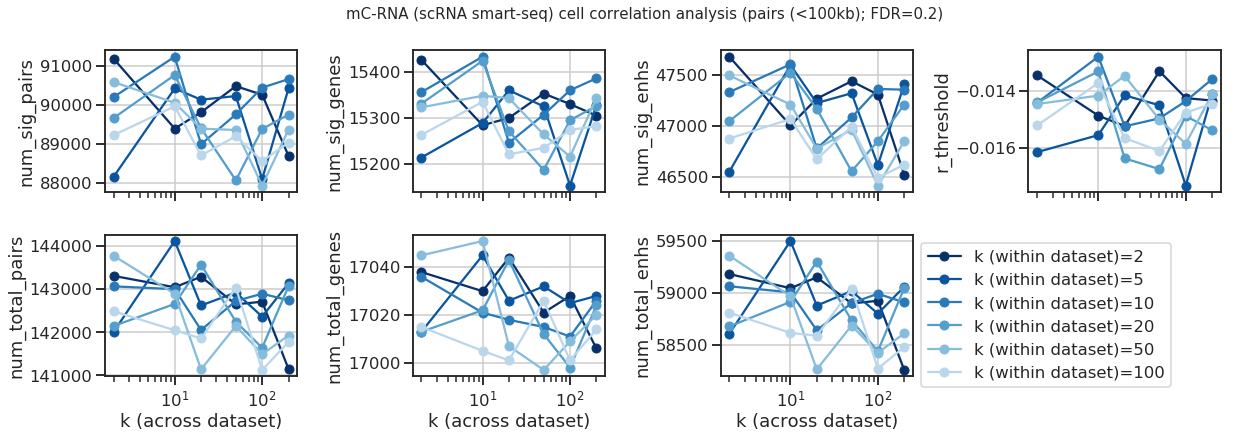

In [228]:
# plot (x - across)
fig, axs = plt.subplots(2, 4, figsize=(5*4, 3*2), sharex=True)
fig.suptitle('mC-RNA (scRNA smart-seq) cell correlation analysis ({}; FDR={})'.format(label, fdr_threshold), 
             fontsize=15)

axs = axs.flatten()
ka_colors = snmcseq_utils.get_grad_colors(len(res['ka'].unique())+2, cmap='Blues_r')
for i_ax, (ax, col) in enumerate(zip(axs, res.columns[2:])):
    for i, (ka, _table) in enumerate(res.groupby('ka')):
        _table = _table.sort_values('k')
        ax.plot(_table['k'], _table[col], '-o', 
                color=ka_colors[i], 
                label='k (within dataset)={}'.format(ka))

    ax.set_xscale('log')
    ax.set_ylabel(col)
    
    if i_ax >= 4:
        ax.set_xlabel('k (across dataset)')
    if i_ax == 6: 
        ax.legend(bbox_to_anchor=(1,1), loc='upper left')
        
axs[-1].axis('off') 
fig.subplots_adjust(wspace=0.6, hspace=0.3)
snmcseq_utils.savefig(fig, output_figure1)
plt.show()

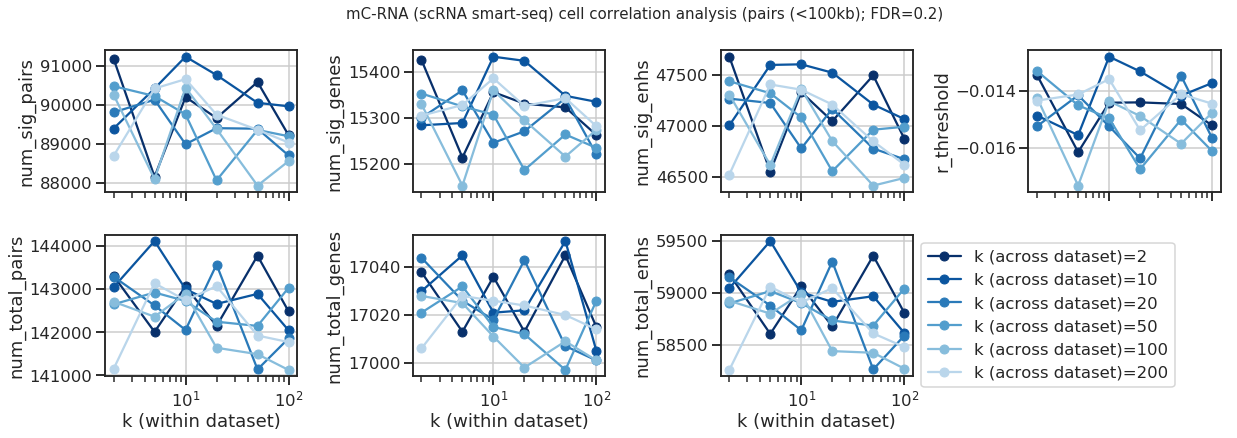

In [229]:
# plot (x - within)

fig, axs = plt.subplots(2, 4, figsize=(5*4, 3*2), sharex=True)
fig.suptitle('mC-RNA (scRNA smart-seq) cell correlation analysis ({}; FDR={})'.format(label, fdr_threshold), 
             fontsize=15)

axs = axs.flatten()
k_colors = snmcseq_utils.get_grad_colors(len(res['ka'].unique())+2, cmap='Blues_r')
for i_ax, (ax, col) in enumerate(zip(axs, res.columns[2:])):
    for i, (k, _table) in enumerate(res.groupby('k')):
        _table = _table.sort_values('ka')
        ax.plot(_table['ka'], _table[col], '-o', 
                color=k_colors[i], 
                label='k (across dataset)={}'.format(k))

    ax.set_xscale('log')
    ax.set_ylabel(col)
    
    if i_ax >= 4:
        ax.set_xlabel('k (within dataset)')
    if i_ax == 6: 
        ax.legend(bbox_to_anchor=(1,1), loc='upper left')
        
axs[-1].axis('off') 
fig.subplots_adjust(wspace=0.6, hspace=0.3)
snmcseq_utils.savefig(fig, output_figure2)
plt.show()

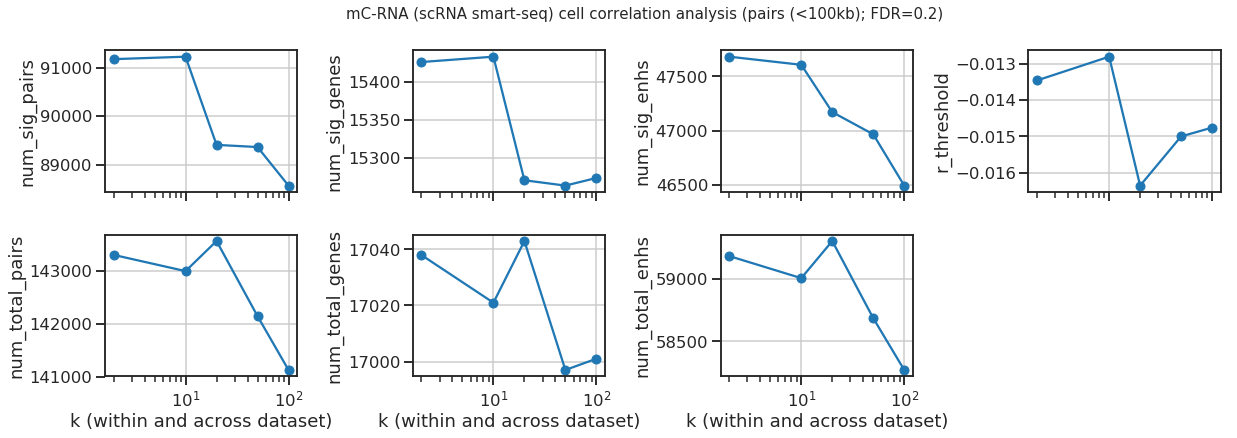

In [230]:
# plot same ks

fig, axs = plt.subplots(2, 4, figsize=(5*4, 3*2), sharex=True)
fig.suptitle('mC-RNA (scRNA smart-seq) cell correlation analysis ({}; FDR={})'.format(label, fdr_threshold), 
             fontsize=15)

axs = axs.flatten()
k_colors = snmcseq_utils.get_grad_colors(len(res['ka'].unique())+2, cmap='Blues_r')
_table = res[res['ka']==res['k']]
_table = _table.sort_values('ka')
for i_ax, (ax, col) in enumerate(zip(axs, res.columns[2:])):
    ax.plot(_table['ka'], _table[col], '-o', 
           )

    ax.set_xscale('log')
    ax.set_ylabel(col)
    
    if i_ax >= 4:
        ax.set_xlabel('k (within and across dataset)')
        
axs[-1].axis('off') 
fig.subplots_adjust(wspace=0.6, hspace=0.3)
snmcseq_utils.savefig(fig, output_figure3)
plt.show()

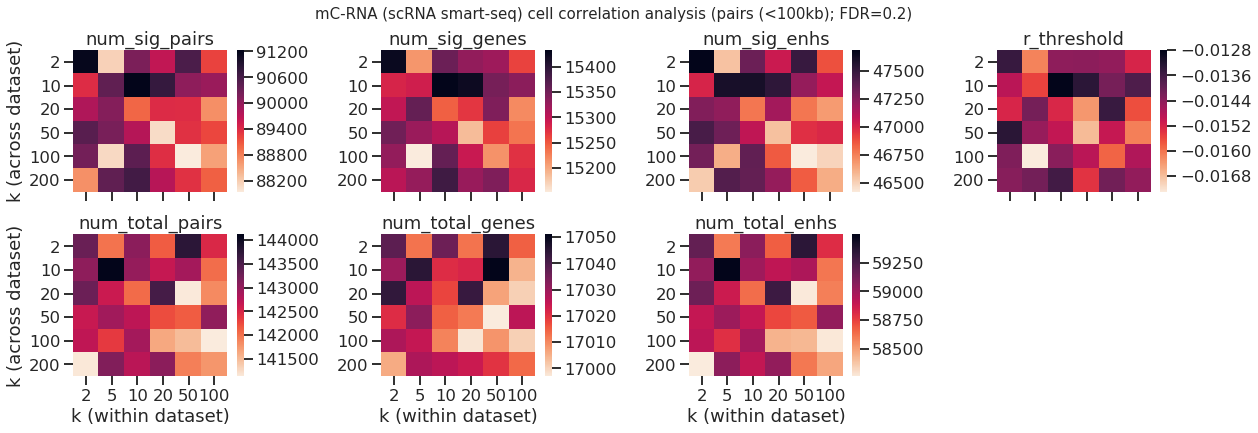

In [231]:
res_pivot = pd.pivot(res, index='k', columns='ka')

# plot same ks
fig, axs = plt.subplots(2, 4, figsize=(5*4, 3*2), sharex=True)
fig.suptitle('mC-RNA (scRNA smart-seq) cell correlation analysis ({}; FDR={})'.format(label, fdr_threshold), 
             fontsize=15)

axs = axs.flatten()
k_colors = snmcseq_utils.get_grad_colors(len(res['ka'].unique())+2, cmap='Blues_r')
_table = res[res['ka']==res['k']]
_table = _table.sort_values('ka')
for i_ax, (ax, col) in enumerate(zip(axs, res.columns[2:])):
    sns.heatmap(res_pivot[col], cmap='rocket_r', ax=ax)

    ax.set_title(col)
    
    if i_ax in (0, 4):
        ax.set_ylabel('k (across dataset)')
    else:
        ax.set_ylabel('')
        
    if i_ax >= 4:
        ax.set_xlabel('k (within dataset)')
    else:
        ax.set_xlabel('')
        
        
axs[-1].axis('off') 
fig.subplots_adjust(wspace=0.6, hspace=0.3)
snmcseq_utils.savefig(fig, output_figure4)
plt.show()

# Plot massive (2nd iteration) 

In [316]:
import sys
sys.path.insert(0, "/cndd/fangming/CEMBA/snmcseq_dev")

from multiprocessing import Pool,cpu_count
from functools import partial

from scipy import sparse
from scipy import stats
import importlib
from __init__ import *
from __init__jupyterlab import *
import snmcseq_utils
importlib.reload(snmcseq_utils)

import pickle
import datetime
from scipy import optimize

In [317]:
today = datetime.date.today()
print(today)

2020-08-07


In [318]:
input_enh_gene_table = '/cndd2/fangming/projects/scf_enhancers/results/200521_to_evals.tsv' 
output_corr_format = '/cndd2/fangming/projects/scf_enhancers/results/corr_analysis_smarter_cells_snmcseq_gene_ka{}_k{}_200803_2020-08-03_corrs.pkl'
output_to_correlate_format = "/cndd2/fangming/projects/scf_enhancers/results/corr_analysis_smarter_cells_snmcseq_gene_ka{}_k{}_200803_2020-08-03_corrs_idx.pkl"

output_figure1 = '/cndd2/fangming/projects/scf_enhancers/results/figures/{}_num_sig_dependency_k_only_v1.pdf'.format(today)
output_figure2 = '/cndd2/fangming/projects/scf_enhancers/results/figures/{}_num_sig_dependency_k_only_v2.pdf'.format(today)
output_figure3 = '/cndd2/fangming/projects/scf_enhancers/results/figures/{}_num_sig_dependency_k_only_v3.pdf'.format(today)
output_figure4 = '/cndd2/fangming/projects/scf_enhancers/results/figures/{}_num_sig_dependency_k_only_v4.pdf'.format(today)

In [319]:
f_pattern = "/cndd2/fangming/projects/scf_enhancers/results/corr_analysis_smarter_cells_snmcseq_gene_*corrs.pkl"
fnames = glob.glob(f_pattern)
iterator = [(int(re.findall("_k[0-9]+", fname)[0][len("_k"):]), 
             int(re.findall("_ka[0-9]+", fname)[0][len("_ka"):]), 
             fname, fname.replace('corrs.pkl', 'corrs_idx.pkl'),
            ) for fname in fnames]
res = []
for k, ka, output_corr, output_to_correlate in iterator:
    print(k, ka)
        # 
#     output_corr = output_corr_format.format(ka, k)
#     output_to_correlate = output_to_correlate_format.format(ka, k)
    
    # try loading the list
    try:
        with open(output_corr, 'rb') as fh:
            corrs, corrs_shuffled, corrs_shuffled_cells = pickle.load(fh)
        print(corrs.shape, corrs_shuffled.shape, corrs_shuffled_cells.shape)

        with open(output_to_correlate, 'rb') as fh:
            to_correlate = pickle.load(fh)
        print(to_correlate.shape)
    except:
        continue
    
    # dists 
    dists = enhancer_gene_to_eval.loc[to_correlate, 'dist'].values
    
    # ## total numbers
    # num_total_pairs = len(enhancer_gene_to_eval[to_correlate])
    # num_total_genes = len(enhancer_gene_to_eval[to_correlate]['gene'].unique())
    # num_total_enhs = len(enhancer_gene_to_eval[to_correlate]['ens'].unique())
    
    
    ## sig numbers
    label_cond = dists < 1e5
    track = corrs[label_cond]
    
    ### total numbers with the condition
    num_total_pairs = len(enhancer_gene_to_eval[to_correlate][label_cond])
    num_total_genes = len(enhancer_gene_to_eval[to_correlate][label_cond]['gene'].unique())
    num_total_enhs = len(enhancer_gene_to_eval[to_correlate][label_cond]['ens'].unique())

    hist_shuff, _ = np.histogram(corrs_shuffled, bins=bins, normed=True)
    cdf_shuff = np.cumsum(hist_shuff)
    # dist
    hist, _ = np.histogram(track, bins=bins, normed=True)
    cdf = np.cumsum(hist)
    # fdr
    fdr = cdf_shuff/cdf

    # get r_threshold
    # remove nan
    isnan = np.isnan(fdr)
    _y = fdr[~isnan]
    _x = bins[1:][~isnan]
    # find r threshold
    try:
        f = lambda _x_func: np.interp(_x_func, _x, _y) - fdr_threshold
        r_threshold = optimize.root_scalar(f, bracket=(-1, 0)).root
    except:
        r_threshold = 0

    sig_table = enhancer_gene_to_eval[to_correlate][label_cond][track<r_threshold]

    # num_sig
    num_sig_pairs = len(sig_table)
    num_sig_genes = len(sig_table['gene'].unique()) 
    num_sig_enhs = len(sig_table['ens'].unique()) 

    # record
    res.append({
        'ka': ka,
        'k': k,
        'num_total_pairs': num_total_pairs,
        'num_total_genes': num_total_genes,
        'num_total_enhs': num_total_enhs,
        'num_sig_pairs': num_sig_pairs,
        'num_sig_genes': num_sig_genes,
        'num_sig_enhs': num_sig_enhs,
        'r_threshold': r_threshold,
    })
    
res = pd.DataFrame(res)[[
            'ka',
            'k',
            'num_sig_pairs',
            'num_sig_genes',
            'num_sig_enhs',
            'r_threshold',
            'num_total_pairs',
            'num_total_genes',
            'num_total_enhs',
]] 
print(res.shape)
res.head()

5 10
(1543792,) (1543792,) (1543792,)
(2589994,)


/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide


5 100
(1535593,) (1535593,) (1535593,)
(2589994,)
9 9
(1516127,) (1516127,) (1516127,)
(2589994,)
200 200
(1531229,) (1531229,) (1531229,)
(2589994,)
5 5
(1548445,) (1548445,) (1548445,)
(2589994,)
20 20
(1549514,) (1549514,) (1549514,)
(2589994,)
100 2
(1539798,) (1539798,) (1539798,)
(2589994,)
50 5
(1542719,) (1542719,) (1542719,)
(2589994,)
5 20
(1541216,) (1541216,) (1541216,)
(2589994,)
40 40
(1536107,) (1536107,) (1536107,)
(2589994,)
100 50
(1527455,) (1527455,) (1527455,)
(2589994,)
50 200
(1522736,) (1522736,) (1522736,)
(2589994,)
15 15
(1533125,) (1533125,) (1533125,)
(2589994,)
75 75
(1544159,) (1544159,) (1544159,)
(2589994,)
500 500
(1519964,) (1519964,) (1519964,)
(2589994,)
50 2
(1539635,) (1539635,) (1539635,)
(2589994,)
6 6
(1533823,) (1533823,) (1533823,)
(2589994,)
2 200
(1531908,) (1531908,) (1531908,)
(2589994,)
50 50
(1533816,) (1533816,) (1533816,)
(2589994,)
200 5
(1543970,) (1543970,) (1543970,)
(2589994,)
200 100
(1529874,) (1529874,) (1529874,)
(2589994,)
1

,ka,k,num_sig_pairs,num_sig_genes,num_sig_enhs,r_threshold,num_total_pairs,num_total_genes,num_total_enhs
0,10,5,4675,931,4379,-0.484508,143012,17030,59048
1,100,5,4269,860,3998,-0.496061,142296,17011,58741
2,9,9,4747,951,4431,-0.443487,140444,16974,57985
3,200,200,3955,796,3709,-0.506771,141820,17005,58579
4,5,5,4907,984,4592,-0.478147,143484,17028,59217


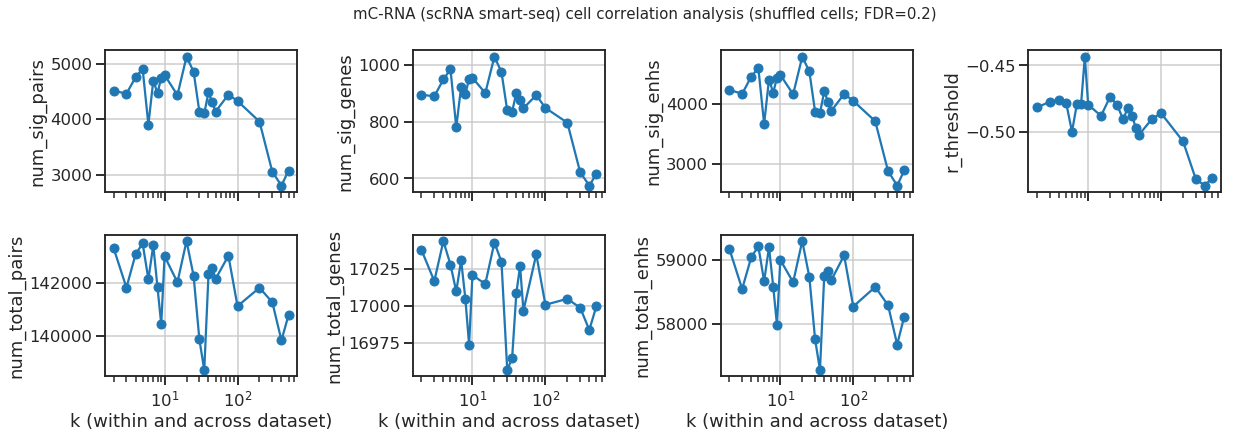

In [320]:
# plot same ks

fig, axs = plt.subplots(2, 4, figsize=(5*4, 3*2), sharex=True)
fig.suptitle('mC-RNA (scRNA smart-seq) cell correlation analysis ({}; FDR={})'.format(label, fdr_threshold), 
             fontsize=15)

axs = axs.flatten()
k_colors = snmcseq_utils.get_grad_colors(len(res['ka'].unique())+2, cmap='Blues_r')
_table = res[res['ka']==res['k']]
_table = _table.sort_values('ka')
for i_ax, (ax, col) in enumerate(zip(axs, res.columns[2:])):
    ax.plot(_table['ka'], _table[col], '-o', 
           )

    ax.set_xscale('log')
    ax.set_ylabel(col)
    
    if i_ax >= 4:
        ax.set_xlabel('k (within and across dataset)')
        
axs[-1].axis('off') 
fig.subplots_adjust(wspace=0.6, hspace=0.3)
snmcseq_utils.savefig(fig, output_figure3)
plt.show()

In [321]:
_table.sort_values('ka')

,ka,k,num_sig_pairs,num_sig_genes,num_sig_enhs,r_threshold,num_total_pairs,num_total_genes,num_total_enhs
22,2,2,4514,894,4229,-0.481292,143311,17038,59180
63,3,3,4455,889,4163,-0.477120,141824,17017,58547
34,4,4,4753,948,4450,-0.475476,143071,17044,59047
4,5,5,4907,984,4592,-0.478147,143484,17028,59217
16,6,6,3899,780,3665,-0.499586,142140,17010,58668
57,7,7,4693,923,4400,-0.479043,143416,17031,59203
39,8,8,4465,896,4182,-0.478928,141833,17005,58584
2,9,9,4747,951,4431,-0.443487,140444,16974,57985
56,10,10,4794,954,4478,-0.479290,143003,17021,59004
12,15,15,4431,900,4155,-0.487710,142024,17015,58654


# Plot massive (3nd iteration) 

In [398]:
import sys
sys.path.insert(0, "/cndd/fangming/CEMBA/snmcseq_dev")

from multiprocessing import Pool,cpu_count
from functools import partial

from scipy import sparse
from scipy import stats
import importlib
from __init__ import *
from __init__jupyterlab import *
import snmcseq_utils
importlib.reload(snmcseq_utils)

import pickle
import datetime
from scipy import optimize

In [399]:
today = datetime.date.today()
print(today)

2020-08-10


In [400]:
input_enh_gene_table = '/cndd2/fangming/projects/scf_enhancers/results/200521_to_evals.tsv' 
output_corr_format = '/cndd2/fangming/projects/scf_enhancers/results/corr_analysis_smarter_cells_snmcseq_gene_ka{}_k{}_200807_2020-08-08_corrs_{}.pkl'
output_to_correlate_format = "/cndd2/fangming/projects/scf_enhancers/results/corr_analysis_smarter_cells_snmcseq_gene_ka{}_k{}_200807_2020-08-08_corrs_idx_{}.pkl"

output_figure1 = '/cndd2/fangming/projects/scf_enhancers/results/figures/{}_num_sig_dependency_k_only_v1.pdf'.format(today)
output_figure2 = '/cndd2/fangming/projects/scf_enhancers/results/figures/{}_num_sig_dependency_k_only_v2.pdf'.format(today)
output_figure3 = '/cndd2/fangming/projects/scf_enhancers/results/figures/{}_num_sig_dependency_k_only_v3.pdf'.format(today)
output_figure4 = '/cndd2/fangming/projects/scf_enhancers/results/figures/{}_num_sig_dependency_k_only_v4.pdf'.format(today)

In [ ]:
f_pattern = "/cndd2/fangming/projects/scf_enhancers/results/corr_analysis_smarter_cells_snmcseq_gene_*_[0-9]_corrs.pkl"
fnames = glob.glob(f_pattern)
iterator = [(int(re.findall("_k[0-9]+", fname)[0][len("_k"):]), 
             int(re.findall("_ka[0-9]+", fname)[0][len("_ka"):]), 
             int(re.findall("[0-9]+_corrs.pkl", fname)[0][:-len("_corrs.pkl")]), 
             fname, fname.replace('corrs', 'corrs_idx'),
            ) for fname in fnames]
res = []
for k, ka, i_sub, output_corr, output_to_correlate in iterator:
    print(k, ka)
        # 
    
    # try loading the list
    try:
        with open(output_corr, 'rb') as fh:
            corrs, corrs_shuffled, corrs_shuffled_cells = pickle.load(fh)
        print(corrs.shape, corrs_shuffled.shape, corrs_shuffled_cells.shape)

        with open(output_to_correlate, 'rb') as fh:
            to_correlate = pickle.load(fh)
        print(to_correlate.shape)
    except:
        continue
    
    # dists 
    dists = enhancer_gene_to_eval.loc[to_correlate, 'dist'].values
    
    # ## total numbers
    # num_total_pairs = len(enhancer_gene_to_eval[to_correlate])
    # num_total_genes = len(enhancer_gene_to_eval[to_correlate]['gene'].unique())
    # num_total_enhs = len(enhancer_gene_to_eval[to_correlate]['ens'].unique())
    
    
    ## sig numbers
    label_cond = dists < 1e5
    track = corrs[label_cond]
    
    ### total numbers with the condition
    num_total_pairs = len(enhancer_gene_to_eval[to_correlate][label_cond])
    num_total_genes = len(enhancer_gene_to_eval[to_correlate][label_cond]['gene'].unique())
    num_total_enhs = len(enhancer_gene_to_eval[to_correlate][label_cond]['ens'].unique())

    hist_shuff, _ = np.histogram(corrs_shuffled, bins=bins, normed=True)
    cdf_shuff = np.cumsum(hist_shuff)
    # dist
    hist, _ = np.histogram(track, bins=bins, normed=True)
    cdf = np.cumsum(hist)
    # fdr
    fdr = cdf_shuff/cdf

    # get r_threshold
    # remove nan
    isnan = np.isnan(fdr)
    _y = fdr[~isnan]
    _x = bins[1:][~isnan]
    # find r threshold
    try:
        f = lambda _x_func: np.interp(_x_func, _x, _y) - fdr_threshold
        r_threshold = optimize.root_scalar(f, bracket=(-1, 0)).root
    except:
        print("failed to detect r_threshold:", k, ka, i_sub)
        continue # failed
#         r_threshold = 0

    sig_table = enhancer_gene_to_eval[to_correlate][label_cond][track<r_threshold]

    # num_sig
    num_sig_pairs = len(sig_table)
    num_sig_genes = len(sig_table['gene'].unique()) 
    num_sig_enhs = len(sig_table['ens'].unique()) 

    # record
    res.append({
        'ka': ka,
        'k': k,
        'i_sub': i_sub,
        'num_total_pairs': num_total_pairs,
        'num_total_genes': num_total_genes,
        'num_total_enhs': num_total_enhs,
        'num_sig_pairs': num_sig_pairs,
        'num_sig_genes': num_sig_genes,
        'num_sig_enhs': num_sig_enhs,
        'r_threshold': r_threshold,
    })
    
res = pd.DataFrame(res)[[
            'ka',
            'k',
            'i_sub',
            'num_sig_pairs',
            'num_sig_genes',
            'num_sig_enhs',
            'r_threshold',
            'num_total_pairs',
            'num_total_genes',
            'num_total_enhs',
]] 
print(res.shape)
res.head()

7 7
(1555266,) (1555266,) (1555266,)
(2589994,)


/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide


75 75
(1516910,) (1516910,) (1516910,)
(2589994,)
8 8
(1553368,) (1553368,) (1553368,)
(2589994,)
50 50
(1534651,) (1534651,) (1534651,)
(2589994,)
6 6
(1553839,) (1553839,) (1553839,)
(2589994,)
300 300
(1528034,) (1528034,) (1528034,)
(2589994,)
9 9
(1534310,) (1534310,) (1534310,)
(2589994,)
10 10
(1536972,) (1536972,) (1536972,)
(2589994,)
75 75
(1542923,) (1542923,) (1542923,)
(2589994,)
7 7
(1548283,) (1548283,) (1548283,)
(2589994,)
8 8
(1525515,) (1525515,) (1525515,)
(2589994,)
50 50
(1551400,) (1551400,) (1551400,)
(2589994,)
300 300
(1516883,) (1516883,) (1516883,)
(2589994,)
6 6
(1528571,) (1528571,) (1528571,)
(2589994,)
10 10
(1534032,) (1534032,) (1534032,)
(2589994,)
9 9
(1555846,) (1555846,) (1555846,)
(2589994,)
8 8
(1541475,) (1541475,) (1541475,)
(2589994,)
75 75
(1501554,) (1501554,) (1501554,)
(2589994,)
7 7
(1531834,) (1531834,) (1531834,)
(2589994,)
9 9
(1554119,) (1554119,) (1554119,)
(2589994,)
2 2
(1545444,) (1545444,) (1545444,)
(2589994,)
6 6
(1538745,) (15

/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in true_divide


failed to detect r_threshold: 10 10 3
2 2
(1543007,) (1543007,) (1543007,)
(2589994,)
50 50
(1525817,) (1525817,) (1525817,)
(2589994,)
300 300
(1523313,) (1523313,) (1523313,)
(2589994,)
4 4
(1517177,) (1517177,) (1517177,)
(2589994,)
8 8
(1536847,) (1536847,) (1536847,)
(2589994,)
25 25
(1544289,) (1544289,) (1544289,)
(2589994,)
30 30
(1525499,) (1525499,) (1525499,)
(2589994,)
25 25
(1551513,) (1551513,) (1551513,)
(2589994,)
30 30
(1504958,) (1504958,) (1504958,)
(2589994,)
75 75
(1524216,) (1524216,) (1524216,)
(2589994,)
10 10
(1528228,) (1528228,) (1528228,)
(2589994,)
2 2
(1551860,) (1551860,) (1551860,)
(2589994,)
6 6
(1545480,) (1545480,) (1545480,)
(2589994,)
4 4
(1541446,) (1541446,) (1541446,)
(2589994,)
30 30
(1520660,) (1520660,) (1520660,)
(2589994,)
25 25
(1548815,) (1548815,) (1548815,)
(2589994,)
75 75
(1523318,) (1523318,) (1523318,)
(2589994,)
10 10
(1549485,) (1549485,) (1549485,)
(2589994,)
4 4
(1539473,) (1539473,) (1539473,)
(2589994,)
6 6
(1548072,) (1548072,

In [ ]:
res_mean = res.groupby(['ka', 'k']).mean().reset_index()
res_std = res.groupby(['ka', 'k']).std().reset_index()

_table = res_mean[res_mean['ka']==res_mean['k']]
_table = _table.sort_values('ka')

_table_std = res_std[res_std['ka']==res_std['k']]
_table_std = _table_std.sort_values('ka')

# _table_std.head()

In [ ]:
# plot same ks

fig, axs = plt.subplots(2, 4, figsize=(5*4, 3*2), sharex=True)
fig.suptitle('mC-RNA (scRNA smart-seq) cell correlation analysis ({}; FDR={})'.format(label, fdr_threshold), 
             fontsize=15)

axs = axs.flatten()
k_colors = snmcseq_utils.get_grad_colors(len(res_mean['ka'].unique())+2, cmap='Blues_r')
for i_ax, (ax, col) in enumerate(zip(axs, res_mean.columns[3:])):
    _x = _table['ka']
    _y = _table[col]
    _y_std = _table_std[col] 
    ax.plot(_x, _y, '-o')
    ax.fill_between(_x, _y-_y_std, _y+_y_std, alpha=0.5)

    ax.set_xscale('log')
    ax.set_ylabel(col)
    
    if i_ax >= 4:
        ax.set_xlabel('k (within and across dataset)')
        
axs[-1].axis('off') 
fig.subplots_adjust(wspace=0.6, hspace=0.3)
snmcseq_utils.savefig(fig, output_figure3)
plt.show()

# Plot massive (3nd iteration - within mC) 

In [386]:
import sys
sys.path.insert(0, "/cndd/fangming/CEMBA/snmcseq_dev")

from multiprocessing import Pool,cpu_count
from functools import partial

from scipy import sparse
from scipy import stats
import importlib
from __init__ import *
from __init__jupyterlab import *
import snmcseq_utils
importlib.reload(snmcseq_utils)

import pickle
import datetime
from scipy import optimize

In [387]:
today = datetime.date.today()
print(today)

2020-08-10


In [388]:
input_enh_gene_table = '/cndd2/fangming/projects/scf_enhancers/results/200521_to_evals.tsv' 

output_figure1 = '/cndd2/fangming/projects/scf_enhancers/results/figures/{}_num_sig_dependency_k_only_v1.pdf'.format(today)
output_figure2 = '/cndd2/fangming/projects/scf_enhancers/results/figures/{}_num_sig_dependency_k_only_v2.pdf'.format(today)
output_figure3 = '/cndd2/fangming/projects/scf_enhancers/results/figures/{}_num_sig_dependency_k_only_v3.pdf'.format(today)
output_figure4 = '/cndd2/fangming/projects/scf_enhancers/results/figures/{}_num_sig_dependency_k_only_v4.pdf'.format(today)

In [391]:
f_pattern = "/cndd2/fangming/projects/scf_enhancers/results/corr_analysis_withinmc_*_[0-9]_corrs.pkl"
fnames = glob.glob(f_pattern)
iterator = [(int(re.findall("_k[0-9]+", fname)[0][len("_k"):]), 
             int(re.findall("_ka[0-9]+", fname)[0][len("_ka"):]), 
             int(re.findall("[0-9]+_corrs.pkl", fname)[0][:-len("_corrs.pkl")]), 
             fname, fname.replace('corrs', 'corrs_idx'),
            ) for fname in fnames]
res = []

CORR_SIGN = -1


for k, ka, i_sub, output_corr, output_to_correlate in iterator:
    print(k, ka)
        # 
    
    # try loading the list
    try:
        with open(output_corr, 'rb') as fh:
            corrs, corrs_shuffled, corrs_shuffled_cells = pickle.load(fh)
            corrs *= CORR_SIGN 
            corrs_shuffled *= CORR_SIGN 
            corrs_shuffled_cells *= CORR_SIGN 
        print(corrs.shape, corrs_shuffled.shape, corrs_shuffled_cells.shape)

        with open(output_to_correlate, 'rb') as fh:
            to_correlate = pickle.load(fh)
        print(to_correlate.shape)
    except:
        continue
    
    # dists 
    dists = enhancer_gene_to_eval.loc[to_correlate, 'dist'].values
    
    # ## total numbers
    # num_total_pairs = len(enhancer_gene_to_eval[to_correlate])
    # num_total_genes = len(enhancer_gene_to_eval[to_correlate]['gene'].unique())
    # num_total_enhs = len(enhancer_gene_to_eval[to_correlate]['ens'].unique())
    
    ## sig numbers
    label_cond = dists < 1e5
    track = corrs[label_cond]
    
    ### total numbers with the condition
    num_total_pairs = len(enhancer_gene_to_eval[to_correlate][label_cond])
    num_total_genes = len(enhancer_gene_to_eval[to_correlate][label_cond]['gene'].unique())
    num_total_enhs = len(enhancer_gene_to_eval[to_correlate][label_cond]['ens'].unique())

    hist_shuff, _ = np.histogram(corrs_shuffled, bins=bins, normed=True)
    cdf_shuff = np.cumsum(hist_shuff)
    # dist
    hist, _ = np.histogram(track, bins=bins, normed=True)
    cdf = np.cumsum(hist)
    # fdr
    fdr = cdf_shuff/cdf

    # get r_threshold
    # remove nan
    isnan = np.isnan(fdr)
    _y = fdr[~isnan]
    _x = bins[1:][~isnan]
    # find r threshold
    try:
        f = lambda _x_func: np.interp(_x_func, _x, _y) - fdr_threshold
        r_threshold = optimize.root_scalar(f, bracket=(-1, 0)).root
    except:
        print("failed to detect r_threshold:", k, ka, i_sub)
        continue # failed
#         r_threshold = 0

    sig_table = enhancer_gene_to_eval[to_correlate][label_cond][track<r_threshold]

    # num_sig
    num_sig_pairs = len(sig_table)
    num_sig_genes = len(sig_table['gene'].unique()) 
    num_sig_enhs = len(sig_table['ens'].unique()) 

    # record
    res.append({
        'ka': ka,
        'k': k,
        'i_sub': i_sub,
        'num_total_pairs': num_total_pairs,
        'num_total_genes': num_total_genes,
        'num_total_enhs': num_total_enhs,
        'num_sig_pairs': num_sig_pairs,
        'num_sig_genes': num_sig_genes,
        'num_sig_enhs': num_sig_enhs,
        'r_threshold': r_threshold,
    })
    
res = pd.DataFrame(res)[[
            'ka',
            'k',
            'i_sub',
            'num_sig_pairs',
            'num_sig_genes',
            'num_sig_enhs',
            'r_threshold',
            'num_total_pairs',
            'num_total_genes',
            'num_total_enhs',
]] 
print(res.shape)
res.head()

300 300
(2589994,) (2589994,) (2589994,)
(2589994,)
10 10
(2459756,) (2459756,) (2459756,)
(2589994,)


/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide


100 100
(2589994,) (2589994,) (2589994,)
(2589994,)
30 30
(2589994,) (2589994,) (2589994,)
(2589994,)
45 45
(2589994,) (2589994,) (2589994,)
(2589994,)
3 3
(648684,) (648684,) (648684,)
(2589994,)
25 25
(2589994,) (2589994,) (2589994,)
(2589994,)
200 200
(2589994,) (2589994,) (2589994,)
(2589994,)
50 50
(2589994,) (2589994,) (2589994,)
(2589994,)
2 2
(214321,) (214321,) (214321,)
(2589994,)
8 8
(2228206,) (2228206,) (2228206,)
(2589994,)
400 400
(2589994,) (2589994,) (2589994,)
(2589994,)
7 7
(2010551,) (2010551,) (2010551,)
(2589994,)
500 500
(2589994,) (2589994,) (2589994,)
(2589994,)
9 9
(2362049,) (2362049,) (2362049,)
(2589994,)
5 5
(1475321,) (1475321,) (1475321,)
(2589994,)
6 6
(1773354,) (1773354,) (1773354,)
(2589994,)
75 75
(2589994,) (2589994,) (2589994,)
(2589994,)
15 15
(2589410,) (2589410,) (2589410,)
(2589994,)
35 35
(2589994,) (2589994,) (2589994,)
(2589994,)
4 4
(1104117,) (1104117,) (1104117,)
(2589994,)
40 40
(2589994,) (2589994,) (2589994,)
(2589994,)
20 20
(2589991

,ka,k,i_sub,num_sig_pairs,num_sig_genes,num_sig_enhs,r_threshold,num_total_pairs,num_total_genes,num_total_enhs
0,300,300,0,3095,1149,2828,-0.938844,242446,18062,100876
1,10,10,0,14004,3291,11951,-0.607594,229972,17971,95667
2,100,100,0,7644,2264,6668,-0.813771,242446,18062,100876
3,30,30,0,11816,3009,10169,-0.706758,242446,18062,100876
4,45,45,0,10719,2861,9264,-0.739754,242446,18062,100876


In [397]:
fnames

['/cndd2/fangming/projects/scf_enhancers/results/corr_analysis_withinmc_ka300_k300_200807_2020-08-10_0_corrs.pkl',
 '/cndd2/fangming/projects/scf_enhancers/results/corr_analysis_withinmc_ka10_k10_200807_2020-08-09_0_corrs.pkl',
 '/cndd2/fangming/projects/scf_enhancers/results/corr_analysis_withinmc_ka100_k100_200807_2020-08-09_0_corrs.pkl',
 '/cndd2/fangming/projects/scf_enhancers/results/corr_analysis_withinmc_ka30_k30_200807_2020-08-09_0_corrs.pkl',
 '/cndd2/fangming/projects/scf_enhancers/results/corr_analysis_withinmc_ka45_k45_200807_2020-08-10_0_corrs.pkl',
 '/cndd2/fangming/projects/scf_enhancers/results/corr_analysis_withinmc_ka3_k3_200807_2020-08-10_0_corrs.pkl',
 '/cndd2/fangming/projects/scf_enhancers/results/corr_analysis_withinmc_ka25_k25_200807_2020-08-09_0_corrs.pkl',
 '/cndd2/fangming/projects/scf_enhancers/results/corr_analysis_withinmc_ka200_k200_200807_2020-08-09_0_corrs.pkl',
 '/cndd2/fangming/projects/scf_enhancers/results/corr_analysis_withinmc_ka50_k50_200807_2020

In [392]:
res_mean = res.groupby(['ka', 'k']).mean().reset_index()
res_std = res.groupby(['ka', 'k']).std().reset_index()

_table = res_mean[res_mean['ka']==res_mean['k']]
_table = _table.sort_values('ka')

_table_std = res_std[res_std['ka']==res_std['k']]
_table_std = _table_std.sort_values('ka')

# _table_std.head()

In [395]:
res

,ka,k,i_sub,num_sig_pairs,num_sig_genes,num_sig_enhs,r_threshold,num_total_pairs,num_total_genes,num_total_enhs
0,300,300,0,3095,1149,2828,-0.938844,242446,18062,100876
1,10,10,0,14004,3291,11951,-0.607594,229972,17971,95667
2,100,100,0,7644,2264,6668,-0.813771,242446,18062,100876
3,30,30,0,11816,3009,10169,-0.706758,242446,18062,100876
4,45,45,0,10719,2861,9264,-0.739754,242446,18062,100876
5,3,3,0,5655,2219,4815,-0.479588,59563,14173,24706
6,25,25,0,12362,3069,10626,-0.691545,242446,18062,100876
7,200,200,0,4863,1537,4371,-0.898042,242446,18062,100876
8,50,50,0,10749,2868,9285,-0.740652,242446,18062,100876
9,2,2,0,2545,1381,2137,-0.427159,19632,8831,8209


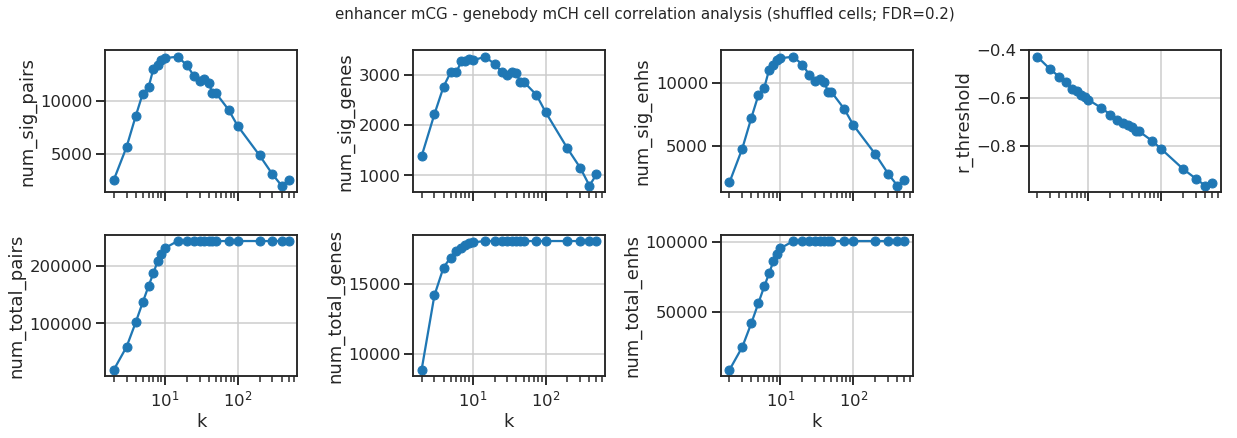

In [393]:
# plot same ks

fig, axs = plt.subplots(2, 4, figsize=(5*4, 3*2), sharex=True)
fig.suptitle('enhancer mCG - genebody mCH cell correlation analysis ({}; FDR={})'.format(label, fdr_threshold), 
             fontsize=15)

axs = axs.flatten()
k_colors = snmcseq_utils.get_grad_colors(len(res_mean['ka'].unique())+2, cmap='Blues_r')
for i_ax, (ax, col) in enumerate(zip(axs, res_mean.columns[3:])):
    _x = _table['ka']
    _y = _table[col]
    _y_std = _table_std[col] 
    ax.plot(_x, _y, '-o')
    ax.fill_between(_x, _y-_y_std, _y+_y_std, alpha=0.5)

    ax.set_xscale('log')
    ax.set_ylabel(col)
    
    if i_ax >= 4:
        ax.set_xlabel('k')
        
axs[-1].axis('off') 
fig.subplots_adjust(wspace=0.6, hspace=0.3)
snmcseq_utils.savefig(fig, output_figure3)
plt.show()